In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData
import hera_pspec as hp
from hera_pspec.data import DATA_PATH
import os

In [2]:
path = '/data4/paper/HERA19Golden/CalibratedData/2457548/LSThrs_20.0_23.0/'
uvd = UVData()
uvd.read_uvh5(path+'zen.2457548.55673_66112.xx.HH.uvcRPC.uvh5')

LSTrng in extra_keywords is a list, array or dict, which will raise an error when writing uvfits or miriad file types
xants in extra_keywords is a list, array or dict, which will raise an error when writing uvfits or miriad file types


In [3]:
lowband = (150,350)
highband = (530,730)

In [4]:
uvd.flag_array.shape

(150138, 1, 1024, 1)

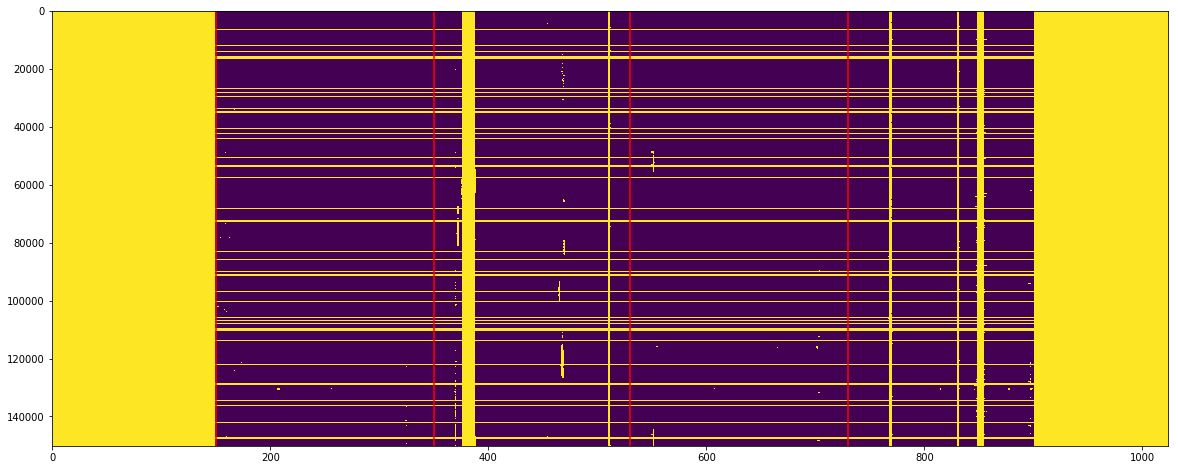

In [5]:
plt.figure(figsize=(20,8))
plt.imshow(uvd.flag_array.squeeze(),aspect='auto')
plt.axvline(lowband[0],color='red')
plt.axvline(lowband[1],color='red')
plt.axvline(highband[0],color='red')
plt.axvline(highband[1],color='red')
plt.show()

In [6]:
low = hp.flags.construct_factorizable_mask([uvd],spw_ranges=[lowband],first='row',greedy_threshold=1.e-6)[0]
high = hp.flags.construct_factorizable_mask([uvd],spw_ranges=[highband],first='row',greedy_threshold=1.e-6)[0]

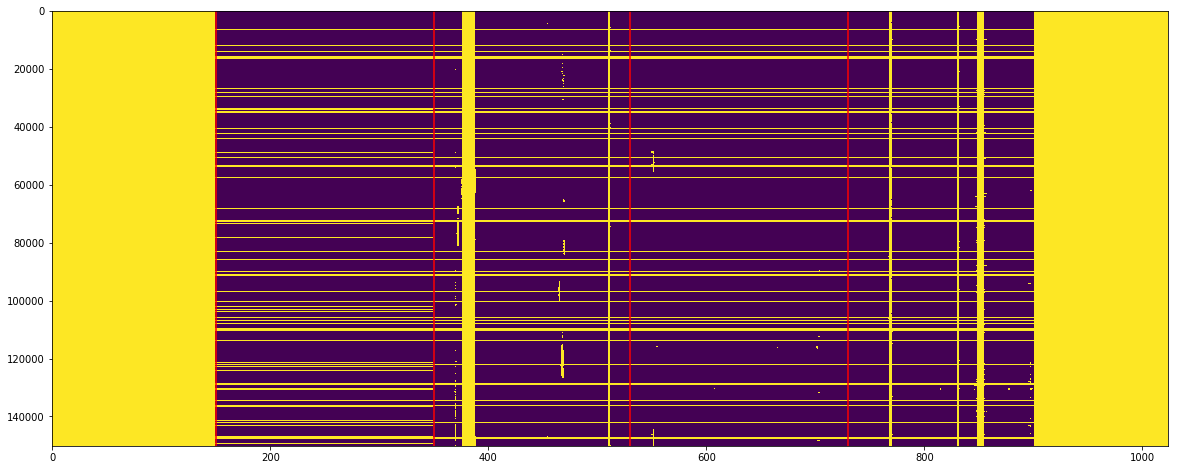

In [7]:
plt.figure(figsize=(20,8))
plt.imshow(low.flag_array.squeeze(),aspect='auto')
plt.axvline(lowband[0],color='red')
plt.axvline(lowband[1],color='red')
plt.axvline(highband[0],color='red')
plt.axvline(highband[1],color='red')
plt.show()

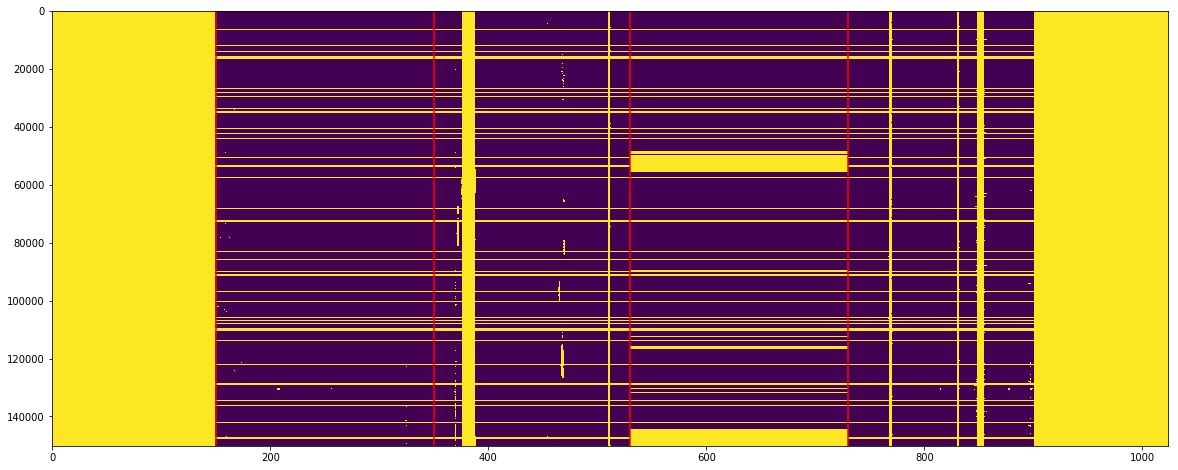

In [8]:
plt.figure(figsize=(20,8))
plt.imshow(high.flag_array.squeeze(),aspect='auto')
plt.axvline(lowband[0],color='red')
plt.axvline(lowband[1],color='red')
plt.axvline(highband[0],color='red')
plt.axvline(highband[1],color='red')
plt.show()

In [9]:
pol = 'xx'
beamfile = os.path.join(DATA_PATH, 'HERA_NF_dipole_power.beamfits')
cosmo = hp.conversions.Cosmo_Conversions()
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)

# Convert to cosmological units (mK)
Jy_to_mK = uvb.Jy_to_mK(np.unique(uvd.freq_array), pol=pol)

In [10]:
def MakeUVP(uvd, Jy_to_mK, spw):

    uvd.data_array *= Jy_to_mK[None, None, :, None]
    
    # Shift data and load datasets
    uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)
    uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)
    ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)

    # Set visibility units
    ds.dsets[0].vis_units = 'mK'
    ds.dsets[1].vis_units = 'mK'

    # Phase data (What does this do?)
    ds.rephase_to_dset(0)
    
    uvp = ds.pspec(
        [(9,20)],
        [(9,20)],
        (0, 1),
        pols=[('xx', 'xx')],
        spw_ranges=spw,
        taper="blackman-harris",
        verbose=True)
    
    return uvp

In [12]:
uvp_high = MakeUVP(high, Jy_to_mK,[highband])
uvp_low = MakeUVP(low, Jy_to_mK, [lowband])
uvp_low_unflag = MakeUVP(uvd, Jy_to_mK, [lowband])
uvp_high_unflag = MakeUVP(uvd, Jy_to_mK, [highband])


Setting spectral range: (530, 730)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((9, 20), (9, 20))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

Setting spectral range: (150, 350)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((9, 20), (9, 20))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

Setting spectral range: (150, 350)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((9, 20), (9, 20))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

Setting spectral range: (530, 730)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((9, 20), (9, 20))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...


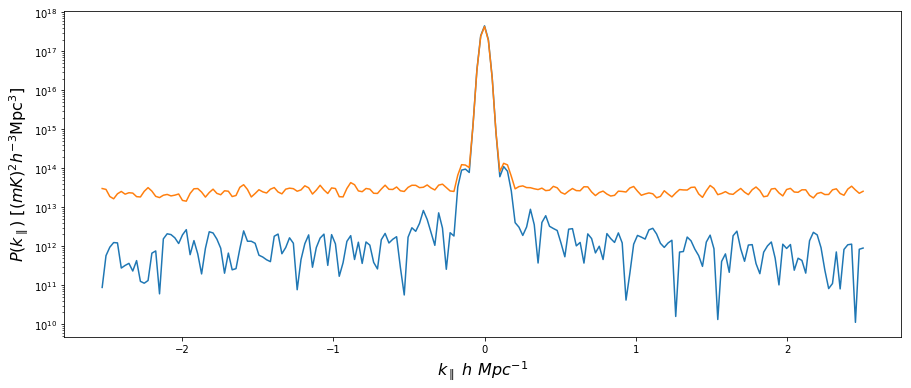

In [34]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
# I guess the above is the thing I should have been doing all these years, but it seems so dumb
hp.plot.delay_spectrum(uvp_low, [((9,20),(9,20))], 0, 'xx', average_blpairs=True, average_times=True, 
                            legend=False, delay=False, ax = ax)
hp.plot.delay_spectrum(uvp_low_unflag, [((9,20),(9,20))], 0, 'xx', average_blpairs=True, average_times=True, 
                       legend=False, delay=False, ax = ax)
plt.show()

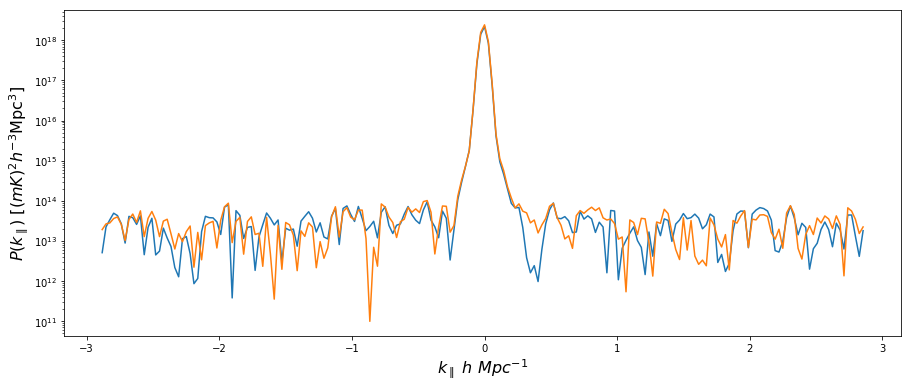

In [35]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
hp.plot.delay_spectrum(uvp_high, [((9,20),(9,20))], 0, 'xx', average_blpairs=True, average_times=True, 
                       legend=False, delay=False, ax = ax)
hp.plot.delay_spectrum(uvp_high_unflag, [((9,20),(9,20))], 0, 'xx', average_blpairs=True, average_times=True, 
                           legend=False, delay=False, ax = ax)